(150, 2)


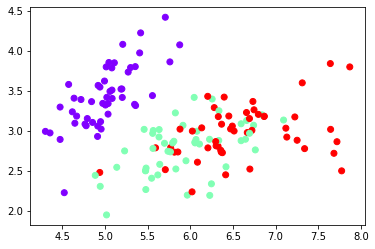

In [3]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import neighbors, datasets
from sklearn.metrics import pairwise_distances
from sklearn.utils import shuffle

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]   # we only take the first two features
X = X + 0.05 * np.random.RandomState(0).randn(*X.shape) # Add random noise since iris has exact values
y = iris.target
X, y = shuffle(X, y, random_state=0)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
print(X.shape)


In [12]:
class SimpleKNNClassifier():
    def __init__(self, X_train, y_train, k=1):
        self.X_train = X_train
        self.y_train = y_train
        self.k = k
        
    def predict(self, X):
        # 1. Compute distances 
        D = np.nan * np.ones((X.shape[0], self.X_train.shape[0]))
        for i, x in enumerate(X):
            for j, xt in enumerate(self.X_train):
                D[i, j] = np.linalg.norm(x-xt)
        # Much faster vectorized version using sklearn's pairwise distances function
        D2 = pairwise_distances(X, self.X_train, metric='euclidean')
        assert np.allclose(D, D2), 'Should be the same'
        print(D2)
        # 2. Get the indices of the top k smallest distances
        sorted_idx = np.argsort(D, axis=1)
        # For each data point get mode
        y = np.array([
            scipy.stats.mode(self.y_train[sidx[:self.k]])[0][0]
            for sidx in sorted_idx
        ])
        # Faster vectorized version
        y_ind = self.y_train[sorted_idx[:,:self.k]]
        y2 = scipy.stats.mode(y_ind, axis=1)[0].ravel()
        assert np.all(y == y2), 'Should be the same'
        return y

k = 1 #3 or 10
knn = SimpleKNNClassifier(X, y, k=k)
y_pred = knn.predict(X)
accuracy = np.mean(y == y_pred)
print(f'The accuracy on the training data for k={k} is: {accuracy*100:.1f}%')

[[0.         0.62673827 1.47749098 ... 0.05431642 2.14688256 1.236059  ]
 [0.62673827 0.         2.10294818 ... 0.57605863 2.35013991 1.70384385]
 [1.47749098 2.10294818 0.         ... 1.52982642 2.25662626 1.27155211]
 ...
 [0.05431642 0.57605863 1.52982642 ... 0.         2.17562969 1.25495218]
 [2.14688256 2.35013991 2.25662626 ... 2.17562969 0.         3.08404293]
 [1.236059   1.70384385 1.27155211 ... 1.25495218 3.08404293 0.        ]]
The accuracy on the training data for k=1 is: 100.0%


## This seems odd, do we really think our method has PERFECT accuracy?

## Suppose we only had 100 points for training and then received 50 new flower measurments

In [ ]:
# Use first 100 points
X_train = X[:100,:]
y_train = y[:100]

# Setup model
for k in [1, 3, 5, 7, 9, 12]:
    knn = SimpleKNNClassifier(X_train, y_train, k=k)

    # Predict on training data
    y_pred = knn.predict(X_train)
    accuracy = np.mean(y_train == y_pred)
    print(f'The accuracy on the training data for k={k} is: {accuracy*100:.1f}%')

    # Now let's test our method on the new flowers
    X_new = X[100:,:]
    y_new = y[100:]
    y_pred = knn.predict(X_new)
    accuracy = np.mean(y_new == y_pred)
    print(f'The accuracy on the new data for k={k} is: {accuracy*100:.1f}%\n')

The accuracy on the training data for k=1 is: 100.0%
The accuracy on the new data for k=1 is: 72.0%

The accuracy on the training data for k=3 is: 83.0%
The accuracy on the new data for k=3 is: 74.0%

The accuracy on the training data for k=5 is: 83.0%
The accuracy on the new data for k=5 is: 78.0%

The accuracy on the training data for k=7 is: 82.0%
The accuracy on the new data for k=7 is: 80.0%

The accuracy on the training data for k=9 is: 82.0%
The accuracy on the new data for k=9 is: 82.0%

The accuracy on the training data for k=12 is: 83.0%
The accuracy on the new data for k=12 is: 82.0%



# The above generalization accuracy estimation algorithm is known as using a train/test split

# Cross validation is a better estimate of generalization accuracy

In [20]:
def cv_estimate(X, k, n_splits=3):
    # Setup split indices
    split_ind = np.floor(np.linspace(0, X.shape[0], num=n_splits+1))
    # Loop over splits
    accuracy_list = []
    for split_start, split_end in zip(split_ind[:-1], split_ind[1:]):
        print(f'split start: {split_start}, split end: {split_end}')

        # Setup boolean array to select test set
        test = np.zeros(X.shape[0], dtype=bool)  # Initialize false boolean array
        test[int(split_start):int(split_end)] = True  # Set test elements to true
        
        # Create train and test sets
        X_train = X[~test, :] # ~ is used to denote "not" for all boolean values
        y_train = y[~test]
        X_test = X[test, :]
        y_test = y[test]
        
        # Train model for this split using X_train and y_train
        knn = SimpleKNNClassifier(X_train, y_train, k=k)
        
        # Compute accuracy on test split
        y_pred = knn.predict(X_test)
        accuracy = np.mean(y_test == y_pred)
        accuracy_list.append(accuracy)
    # Take mean of accuracy
    return np.mean(accuracy_list)

for k in [1, 3, 5, 7, 9, 12]:
    # n_splits is often 3, 5, 10; X.shape[0] (i.e., one split per sample) is known as Leave One Out (LOO)
    cv_acc = cv_estimate(X, k, n_splits=3) 
    print(f'CV accuracy estimate for k={k} is {100*cv_acc:.1f}%')

split start: 0.0, split end: 50.0
[[0.37427613 1.95119417 0.77840387 ... 0.05431642 2.14688256 1.236059  ]
 [0.42810364 1.87783586 1.23783785 ... 0.57605863 2.35013991 1.70384385]
 [1.78915368 2.67416203 1.17812446 ... 1.52982642 2.25662626 1.27155211]
 ...
 [1.44515281 1.10673845 0.47851951 ... 1.15421223 1.02399439 2.12064647]
 [0.45381192 1.81084602 1.18531365 ... 0.5603914  2.28121873 1.72417106]
 [1.08185582 1.07670143 0.98177503 ... 0.95541522 1.62234341 2.20116443]]
split start: 50.0, split end: 100.0
[[0.37427613 0.42810364 1.78915368 ... 0.32441088 2.45611469 1.27594635]
 [1.95119417 1.87783586 2.67416203 ... 1.95590791 0.98077708 3.1245928 ]
 [0.77840387 1.23783785 1.17812446 ... 0.82260594 1.45453294 1.64692792]
 ...
 [1.13754807 1.7265447  0.73662611 ... 1.17658429 2.65635597 0.53900339]
 [1.37229973 1.42745007 2.078553   ... 1.38480281 0.9620455  2.51140001]
 [0.9953315  1.5840181  0.79025583 ... 1.03398325 2.58093095 0.5387729 ]]
split start: 100.0, split end: 150.0
[[1.4